In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook as tqdm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import parmap
from multiprocess import Pool
import warnings
warnings.filterwarnings("ignore")

In [2]:
def kernel_linear(a, b):
    return np.dot(a, b)

def kernel_sigmoid(a, b, gamma=1, k0=0):
    return np.tanh(gamma * np.dot(a, b) + k0)

def kernel_rbf(a, b, gamma=0.5):
    return np.exp(-gamma * np.power(np.linalg.norm(a - b), 2))

def kernel_poly(a, b, gamma=1, k0=1, degree=3):
    return np.power(gamma * np.dot(a, b) + k0, degree)

def get_kernel_func(name, gamma=1, k0=1, degree=3):
    if name == "linear":
        return lambda a, b: kernel_linear(a, b)
    elif name == "sigmoid":
        return lambda a, b: kernel_sigmoid(a, b, gamma, k0)
    elif name == "rbf":
        return lambda a, b: kernel_rbf(a, b, gamma)
    elif name == "poly":
        return lambda a, b: kernel_poly(a, b, gamma, k0, degree)
    else:
        return lambda a, b: kernel_linear(a, b)

In [3]:
def calc_kenrel_matrix(kernel_func, A, B):
    n, *_ = A.shape
    m, *_ = B.shape
    f = lambda i, j: kernel_func(A[i], B[j])
    return np.fromfunction(np.vectorize(f), (n, m), dtype=int)

In [78]:
def read_dataset(filename):
    data = pd.read_csv(filename)
    X = data.values[:, :-1]
    tmp_y = data.values[:, -1]
    y = np.vectorize(lambda t: 1 if t == 'P' else -1)(tmp_y)
    indices = np.arange(y.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [79]:
class SVM:
    def __init__(self, kernef_f, X, y, C=1.0):
        n, *_ = y.shape
        self.N = n
        self.kernef_f = kernef_f
        self.y = y
        self.kernel = calc_kenrel_matrix(kernef_f, X, X)
        self.X = X
        self.C = C
        
        self.alphas = np.zeros(n)
        self.b = 0
        
        self.EPS = 1e-6
        self.MAX_ITERATIONS = 3000
        
    def predict(self, x):
        kernel = calc_kenrel_matrix(self.kernef_f, np.array([x]), self.X)
        res = int(np.sign(np.sum(self.alphas * self.y * kernel[0]) + self.b))
        return res if res != 0 else 1
    
    def get_random_j(self, i):
        res = np.random.randint(0, self.N - 1);
        return res if res < i else res + 1
    
    def calc_U_V(self, i, j):
        a_i, a_j = self.alphas[i], self.alphas[j]
        if self.y[i] == self.y[j]:
            U = max(0, a_i + a_j - self.C)
            V = min(self.C, a_i + a_j)
        else:
            U = max(0, a_j - a_i)
            V = min(self.C, self.C + a_j - a_i)
        return U, V
    
    def calc_E(self, i):
        return np.dot(self.alphas * self.y, self.kernel[i]) - self.y[i]
    
    def get_b(self, i):
        return 1 / self.y[i] - np.dot(self.alphas * self.y, self.kernel[i])
    
    def calc_b(self):
        self.b = 0
        idx = None
        for i in range(self.N):
            if self.EPS < self.alphas[i] and self.alphas[i] + self.EPS < self.C:
                idx = i
                break
        if idx is None:
            cnt = 0
            for i in range(self.N):
                if self.EPS < self.alphas[i]:
                    self.b += self.get_b(i)
                    cnt += 1
            if cnt != 0:
                self.b /= cnt
        else:
            self.b = self.get_b(idx)
            
    def fit(self):
        indices = np.arange(self.N)
        for _ in range(self.MAX_ITERATIONS):
            np.random.shuffle(indices)
            for i_fake in range(self.N):
                i = indices[i_fake]
                j = indices[self.get_random_j(i_fake)]
                E_i = self.calc_E(i)
                E_j = self.calc_E(j)
                prev_a_i = self.alphas[i]
                prev_a_j = self.alphas[j]
                U, V = self.calc_U_V(i, j)
                if V - U < self.EPS:
                    continue
                eta = 2 * self.kernel[i][j] - (self.kernel[i][i] + self.kernel[j][j])
                if eta > -self.EPS:
                    continue
                possible_new_a_j = prev_a_j + self.y[j] * (E_j - E_i) / eta
                new_a_j = min(max(U, possible_new_a_j), V)
                if abs(new_a_j - prev_a_j) < self.EPS:
                    continue
                self.alphas[j] = new_a_j
                self.alphas[i] += self.y[i] * self.y[j] * (prev_a_j - new_a_j)
        self.calc_b()
            
    def get_suport_indices(self):
        return np.where(np.logical_and(self.EPS < self.alphas,
                                       self.alphas + self.EPS < self.C))

In [80]:
Cs = [0.1, 1.0, 10.0, 25.0, 50.0, 100.0]
linear_params = [{"name": "linear", "C": C} for C in Cs]
rbf_params = [{"name": "rbf", "gamma": gamma, "C": C} 
             for gamma in [0.1, 0.3, 0.5]
             for C in Cs]
sigmoid_params = [{"name": "sigmoid", "gamma": gamma, "k0": k0, "C": C}
                 for gamma in [0.5, 0.75, 1.0]
                 for k0 in [0.0, 0.5, 1.0]
                 for C in Cs]
poly_params = [{"name": "poly", "gamma": gamma, "k0": k0, "C": C, "degree": degree}
               for gamma in [0.01, 0.5, 1.0]
               for k0 in [0, 0.5, 1]
               for degree in [3, 4, 5]
               for C in Cs]
all_params = np.array(linear_params + rbf_params + sigmoid_params + poly_params)

In [90]:
def get_clf(params, X, y):
    name = params["name"]
    C = params["C"]
    gamma = params.get("gamma", None)
    k0 = params.get("k0", None)
    degree = params.get("degree", None)
    kernel_f = get_kernel_func(name, gamma, k0, degree)
    clf = SVM(kernel_f, X, y, C)
    clf.fit()
    return clf

def get_score(params, X, y):
    kf = KFold(4)
    f_scores = []
    for train_index, test_index in kf.split(X):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        clf = get_clf(params, X_train, y_train)
        y_pred = np.apply_along_axis(lambda x: clf.predict(x), 1, X_test)
        f_scores.append(f1_score(y_test, y_pred))
    return np.average(np.array(f_scores))    

def get_best_params(X, y):
    best_score = -1
    best_params = None
    total_params, *_ = all_params.shape
    with Pool(7) as P:
        scores = list(tqdm(P.imap(lambda params: get_score(params, X, y), all_params), total=total_params))
    return all_params[np.argmax(np.array(scores))]

In [112]:
def draw(clf, X, y, step):
    stepx = step
    stepy = 0.01
    x_min, y_min = np.amin(X, 0)
    x_max, y_max = np.amax(X, 0)
    x_min -= stepx
    x_max += stepx
    y_min -= stepy
    y_max += stepy
    xx, yy = np.meshgrid(np.arange(x_min, x_max, stepx),
                         np.arange(y_min, y_max, stepy))
    
    mesh_dots = np.c_[xx.ravel(), yy.ravel()]
    zz = np.apply_along_axis(lambda t: clf.predict(t), 1, mesh_dots)
    zz = np.array(zz).reshape(xx.shape)
    
    plt.figure(figsize=(10, 10))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    x0, y0 = X[y == -1].T
    x1, y1 = X[y == 1].T
    
    plt.pcolormesh(xx, yy, zz, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.scatter(x0, y0, color='red', s=100)
    plt.scatter(x1, y1, color='blue', s=100)
    
    sup_ind = clf.get_suport_indices()
    X_sup = X[sup_ind]
    x_sup, y_sup = X_sup.T
    
    plt.scatter(x_sup, y_sup, color='white', marker='x', s=60)
    plt.show()

In [93]:
def get_best_clf(filename):
    X, y = read_dataset(filename)
    params = get_best_params(X, y)
    print(params)
    print(get_score(params, X, y))
    return get_clf(params, X, y)

In [94]:
chips_clf = get_best_clf("chips.csv")


{'name': 'poly', 'gamma': 0.5, 'k0': 0.5, 'C': 50.0, 'degree': 5}
0.8384813384813384


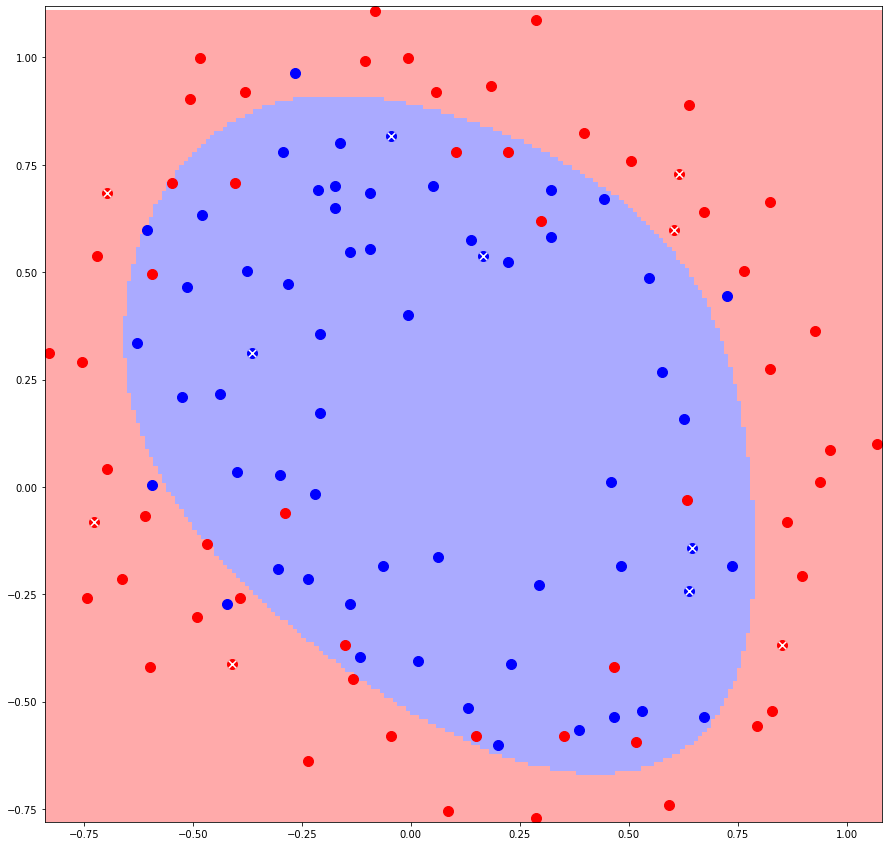

In [107]:
chips_X, chips_y = read_dataset("chips.csv")
draw(chips_clf, chips_X, chips_y, 0.01)

In [108]:
geyser_clf = get_best_clf("geyser.csv")


{'name': 'linear', 'C': 100.0}
0.8662235563178959


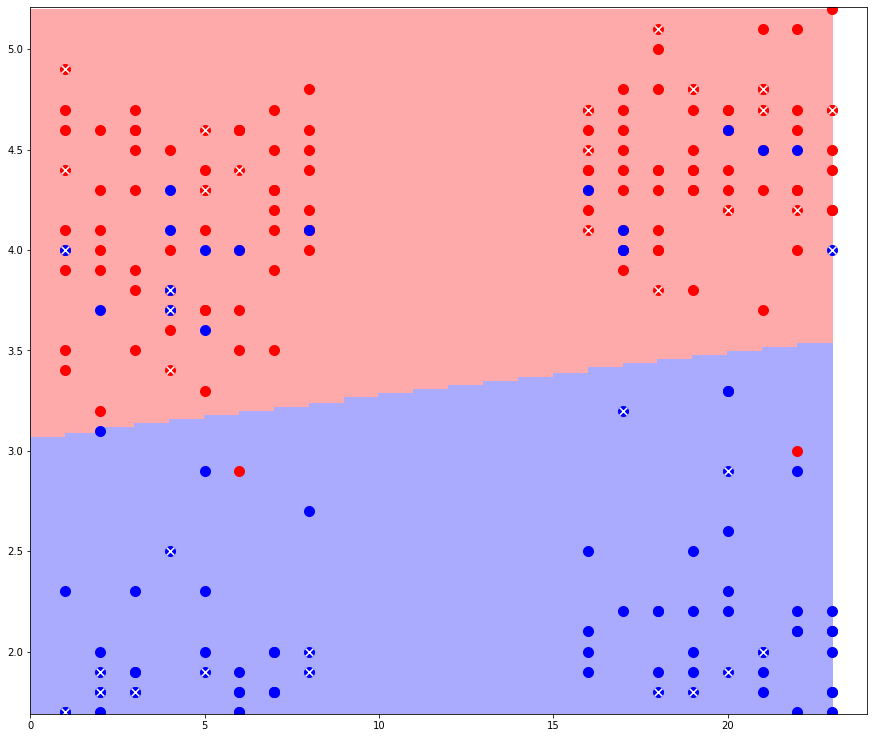

In [111]:
geyser_X, geyser_y = read_dataset("geyser.csv")
draw(geyser_clf, geyser_X, geyser_y, 1)